In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl 
import seaborn as sns 
import pickle

from tqdm import tqdm

from src.utils.windows import sliding_window_rect

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from keras.layers import Input, Conv2D, Dropout, BatchNormalization, \
    AveragePooling2D, GlobalAveragePooling2D, Activation, Lambda, ZeroPadding1D, \
    MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Concatenate, Reshape, \
    Conv2DTranspose, UpSampling2D
    
from keras.models import Model
from torch import nn, optim
from keras import backend as K

sns.set_style('darkgrid')
sns.set_context('paper')

%matplotlib inline

In [19]:
def eulerAnglesToRotationMatrix(theta) :
    ones = np.ones(theta.shape[0])
    zero = np.zeros(theta.shape[0])
    
    R_x = np.asarray([
        [ones, zero, zero],
        [zero, np.cos(theta[:, 0]), -np.sin(theta[:, 0])], 
        [zero, np.sin(theta[:, 0]),  np.cos(theta[:, 0])], 
    ]).transpose(2, 0, 1)

    R_y = np.asarray([
        [np.cos(theta[:, 1]), zero, np.sin(theta[:, 1])],
        [zero, ones, zero],
        [-np.sin(theta[:, 1]), zero, np.cos(theta[:, 1])]
    ]).transpose(2, 0, 1)
                 
    R_z = np.array([
        [np.cos(theta[:, 2]), -np.sin(theta[:, 2]), zero],
        [np.sin(theta[:, 2]), np.cos(theta[:, 2]), zero],
        [zero, zero, ones]
    ]).transpose(2, 0, 1)
                     
    R = np.einsum('abc,acd->abd', R_z, np.einsum('abc,acd->abd', R_y, R_x))
#     R_old = np.dot(R_z[0], np.dot(R_y[0], R_x[0]))
#     assert np.allclose(R[0], np.dot(R_z[0], np.dot(R_y[0], R_x[0])))
 
    return R

In [20]:
# # def load_modality(modality, n_rotations=0):
# #     accel = pickle.load(open(f'{modality}-waist-body.pkl', 'rb'))
# #     index = pickle.load(open('index.pkl', 'rb'))
# #     label = pickle.load(open('label.pkl', 'rb'))

# #     inds = (
# #         (label.track_0.apply(lambda ll: 'walk' in ll)) &
# #         (index.subject == 2)
# #     )

# #     accel, index, label = accel[inds], index[inds], label[inds]

# # #     rng = np.random.RandomState(1234)
# #     accel = sliding_window_rect(accel.values, 32, 7).transpose(0, 2, 1)

#     accel_rot = []

#     for _ in tqdm(range(100), total=100):
#         R = eulerAnglesToRotationMatrix(rng.uniform(-np.pi, np.pi, (accel.shape[0], 3)))
#         rots = np.einsum('ijk,ijl->ijk', accel, R)
#         accel_rot.extend(np.concatenate(rots, axis=0))
#     accel_rot = np.asarray(accel_rot)
# #     norms = np.linalg.norm(accel_rot, axis=1)
# #     norm_ord = np.argsort(-norms)
# #     accel = accel_rot[:, :]
# #     print(accel.shape)

# #     norms = np.linalg.norm(accel, axis=1, keepdims=True)
# #     inds = np.argsort(-norms.ravel(), axis=0)

# #     accel = accel[inds[:100000]]

# #     inds = rng.permutation(accel.shape[0])
# #     accel = accel[inds][:, None, :]

# #     print(accel.shape)

%ls

Untitled-Copy1.ipynb       accel-waist-body-jerk.pkl  accel-waist-grav.pkl       fold.pkl@                  gyro-waist-body.pkl        index.pkl@                 mldb@                      statistical_features/
Untitled.ipynb             accel-waist-body.pkl       accel.torch                gyro-waist-body-jerk.pkl   gyro.torch                 label.pkl@                 src@


In [52]:
def load_modality(modality, n_rotations=0):
    if modality == 'accel':
        data = pickle.load(open(f'{modality}-waist-body.pkl', 'rb'))
    elif modality == 'gyro':
        data = pickle.load(open(f'{modality}-waist-body.pkl', 'rb'))
    else:
        raise ValueError
    index = pickle.load(open('index.pkl', 'rb'))
    label = pickle.load(open('label.pkl', 'rb'))

    inds = (
        (label.track_0.apply(lambda ll: 'walk' in ll)) &
        (index.subject == 2)
    )

    data, index, label = data[inds], index[inds], label[inds]
    data = sliding_window_rect(data.values, 32, 7).transpose(0, 2, 1)
    
    data_rot = []
    data_rot.extend(np.concatenate(data, axis=0))
    rng = np.random.RandomState(1234)
    for _ in range(n_rotations):
        R = eulerAnglesToRotationMatrix(
            rng.uniform(-np.pi, np.pi, (data.shape[0], 3)) * dict(gyro=0, accel=1)[modality]
        )
        rots = np.einsum('ijk,ijl->ijk', data, R)
        data_rot.extend(np.concatenate(rots, axis=0))
    data = np.asarray(data_rot)

    norms = np.linalg.norm(data, axis=1, keepdims=True)
    inds = np.argsort(-norms.ravel(), axis=0)

    return data[:, None, :], inds


n_rotations = 100

accel_np, accel_inds = load_modality('accel', n_rotations=n_rotations)
gyro_np, gyro_inds = load_modality('gyro', n_rotations=n_rotations)
print(accel_np.shape, gyro_np.shape)

N = 100000
inds = np.sort(list(set(accel_inds[:N]) | set(gyro_inds[:N])))
accel_np, gyro_np = accel_np[inds], gyro_np[inds]
print(accel_np.shape, gyro_np.shape)

accel_torch, gyro_torch = torch.from_numpy(accel_np).float(), torch.from_numpy(gyro_np).float()

(852036, 1, 32) (852036, 1, 32)
(169886, 1, 32) (169886, 1, 32)


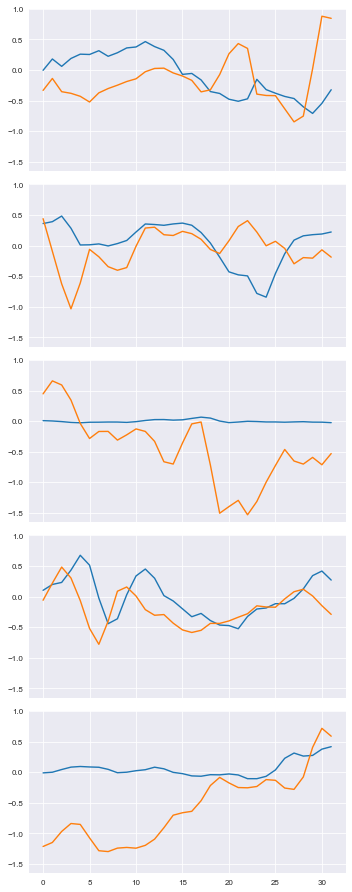

In [53]:
N = 5
fig, axes = pl.subplots(N, 1, sharex=True, sharey=True, figsize=(5, 2.5 * N))
rng = np.random.RandomState(1234)
for ii, ax in zip(rng.permutation(len(accel_np)), axes): 
    ax.plot(accel_np[ii, 0])
    ax.plot(gyro_np[ii, 0])
pl.tight_layout()

In [67]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
    
class Identity(nn.Module): 
    def forward(self, x): 
        return x
    
    
class UnFlatten(nn.Module):
    def __init__(self, shape_func): 
        super(UnFlatten, self).__init__()
        self.shape_func = shape_func
        
    def forward(self, input, size=64):
        return input.view(self.shape_func(input.shape))
    
class ConvUnit(nn.Sequential): 
    def __init__(self, in_channels, out_channels, stride, padding=0, kernel_size=5): 
        super(ConvUnit, self).__init__(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                padding=padding, 
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(), 
            nn.MaxPool1d(stride), 
        )
        
class ConvTransposeUnit(nn.Sequential): 
    def __init__(self, in_channels, out_channels, stride, padding=0, output_padding=0, kernel_size=5, last=False): 
        super(ConvTransposeUnit, self).__init__(
            nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride,
                output_padding=output_padding,
                padding=padding,
            ),
            Identity() if last else nn.ReLU() , 
        )
        
def print_sizes(vae, x): 
    x = torch.Tensor(x)
    print('\nencoding')
    print(x.shape)
    for layer in vae.encoder.children(): 
        x = layer(x)
        print(x.shape)
        
    print('\nlatent')
    mu, log_var = vae.mu(x), vae.log_var(x)
    print(mu.shape, log_var.shape)
    
    print('\ncode')
    z = vae.reparameterise(mu, log_var)
    print(z.shape)
    
    print('\nlin')
    x = vae.lin(z)
    print(x.shape)
    
    print('\ndecoding')
    print(x.shape)
    for layer in vae.decoder.children(): 
        x = layer(x)
        print(x.shape)
        
        
class VAE(nn.Module): 
    def __init__(self, z_hidden): 
        super(VAE, self).__init__() 
        
        sizes = [
            4, 8, 16, 32, 64 
        ]
        
#         sizes = [16] * len(sizes)
        
        k = 3
        p = 1
        op = 1
        
        self.encoder = nn.Sequential(
            ConvUnit(1,        sizes[0], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[0], sizes[1], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[1], sizes[2], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[2], sizes[3], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[3], sizes[4], stride=2, padding=p, kernel_size=k),
            Flatten(),
        )
        
        self.decoder = nn.Sequential(
            UnFlatten(lambda shape: (shape[0], sizes[-1], 1)),
            ConvTransposeUnit(sizes[4], sizes[3], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[3], sizes[2], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[2], sizes[1], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[1], sizes[0], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[0],        1, stride=2, padding=p, kernel_size=k, output_padding=op, last=True),
        )
        
#         self.mu = nn.Linear(sizes[-1], z_hidden)
#         self.log_var = nn.Linear(sizes[-1], z_hidden)
#         self.lin = nn.Linear(z_hidden, sizes[-1])
        # print_sizes(self, accel_torch[:100])
        
    def encode(self, x): 
        z = self.encoder(x) 
#         mu = self.mu(z)
#         log_var = self.log_var(z)
#         z_hat = self.reparameterise(mu, log_var)
        return z, z, z, z
    
    def reparameterise(self, mu, log_var): 
        std = F.softplus(log_var) 
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    
    def decode(self, x): 
#         x = self.lin(x)
        return self.decoder(x)
    
    def forward(self, x): 
        z, mu, log_var, z_hat = self.encode(x)
        x_hat = self.decode(z_hat)
        return mu, log_var, z_hat, x_hat
        
    def kl_loss(self, mu, log_var): 
        loss = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp()) 
        return loss.sum(1).mean() 
    
    def mse_loss(self, x, x_hat): 
        loss = (x - x_hat).pow(2)
        return loss.sum((1, 2)).mean()
    
    def loss_func(self, x, x_hat, mu, log_var): 
        return (
            self.mse_loss(x, x_hat),
            self.kl_loss(mu, log_var) 
        )
    
#     def learn_step(self, x, y): 
        
        
class MultiSourceVAE(nn.Module): 
    def __init__(self, z_hidden): 
        super(MultiSourceVAE, self).__init__() 
        
        self.accel = VAE(z_hidden=z_hidden)
        self.gyro = VAE(z_hidden=z_hidden) 
    
    def forward(self, accel, gyro): 
        mu_a, log_var_a, z_accel, accel_hat = self.accel.forward(accel)
#         mu_g, log_var_g, z_gyro, gyro_hat = self.gyro.forward(gyro)
        
        accel_from_accel = accel_hat
        gyro_from_accel = self.gyro.decode(z_accel)
        
        return accel_hat, gyro_hat, accel_from_gyro, gyro_from_accel, z_accel, z_gyro
        
    def loss(self, accel, gyro, accel_hat, gyro_hat, accel_from_gyro, gyro_from_accel, z_accel, z_gyro):
        return sum((
            (accel - accel_hat).pow(2).sum((1, 2)).mean(), 
            (gyro - gyro_hat).pow(2).sum((1, 2)).mean()
        )), sum((
            (accel - accel_from_gyro).pow(2).sum((1, 2)).mean(), 
            (gyro - gyro_from_accel).pow(2).sum((1, 2)).mean(), 
        )), (z_accel - z_gyro).pow(2).sum(1).mean()

    
class MultiModalVAE(nn.Module): 
    def __init__(self, z_hidden): 
        super(MultiModalVAE, self).__init__() 
        
        self.accel = VAE(z_hidden=z_hidden)
        self.gyro = VAE(z_hidden=z_hidden) 
    
    def forward(self, accel, gyro): 
        mu, log_var, zz, _ = self.accel.forward(accel)
        
        accel_from_accel = self.accel.decode(zz)
        gyro_from_accel = self.gyro.decode(zz)
        
        return accel_from_accel, gyro_from_accel, mu, log_var, zz
        
    def loss(self, accel, gyro, accel_from_accel, gyro_from_accel, mu, log_var, zz):
        return (
            (accel - accel_from_accel).pow(2).sum((1, 2)).mean(), 
            (gyro - gyro_from_accel).pow(2).sum((1, 2)).mean()
        )



In [68]:
def learn_batch(accel_torch, gyro_torch, msvae, adam):
    data_loader = torch.utils.data.DataLoader(
        torch.arange(accel_torch.shape[0])[:, None], batch_size=100, shuffle=True
    )
    train_loss = 0
    for batch_idx, inds in enumerate(data_loader): 
        adam.zero_grad() 
        inds = np.asarray(inds.tolist()).ravel()
        accel_batch, gyro_batch = accel_torch[inds], gyro_torch[inds]
        accel_from_accel, gyro_from_accel, mu, log_var, zz = \
            msvae.forward(accel_batch, gyro_batch)

        l_aa, l_ag = msvae.loss(
            accel_batch, gyro_batch, 
            accel_from_accel, gyro_from_accel, 
            mu, log_var, zz
        )
        
        loss = l_aa + l_ag / 3
        
        loss.backward(retain_graph=True)
        train_loss += loss.item()
        adam.step()
        
        if batch_idx % 100 == 0:
            print('    Epoch: {:3d}% {:6d}/{:6d}; l_aa: {:3.6f}; l_ag: {:3.6f}'.format(
                int(100.0 * batch_idx / len(data_loader)), batch_idx, len(data_loader), 
                l_aa, l_ag))
            
def learn(n_rep, accel_torch, gyro_torch, msvae, adam): 
    for it in range(n_rep): 
        print(f'Iter {it + 1} / {n_rep}...')
        learn_batch(accel_torch, gyro_torch, msvae, adam)

In [70]:
msvae = MultiModalVAE(32)
learn(2, accel_torch, gyro_torch, msvae, optim.Adam(msvae.parameters(), 1e-2))
learn(4, accel_torch, gyro_torch, msvae, optim.Adam(msvae.parameters(), 1e-3))
learn(8, accel_torch, gyro_torch, msvae, optim.Adam(msvae.parameters(), 1e-4))

Iter 1 / 2...
    Epoch:   0%      0/  1699; l_aa: 6.364057; l_ag: 19.831806
    Epoch:   5%    100/  1699; l_aa: 1.125181; l_ag: 11.303854
    Epoch:  11%    200/  1699; l_aa: 1.149222; l_ag: 13.188892
    Epoch:  17%    300/  1699; l_aa: 0.934293; l_ag: 12.849026
    Epoch:  23%    400/  1699; l_aa: 0.858657; l_ag: 13.204419
    Epoch:  29%    500/  1699; l_aa: 0.621310; l_ag: 13.868979
    Epoch:  35%    600/  1699; l_aa: 0.658050; l_ag: 13.006121
    Epoch:  41%    700/  1699; l_aa: 0.557524; l_ag: 11.811199
    Epoch:  47%    800/  1699; l_aa: 0.621577; l_ag: 13.477497
    Epoch:  52%    900/  1699; l_aa: 0.669633; l_ag: 13.953935
    Epoch:  58%   1000/  1699; l_aa: 0.698485; l_ag: 12.508904
    Epoch:  64%   1100/  1699; l_aa: 0.534417; l_ag: 12.717920
    Epoch:  70%   1200/  1699; l_aa: 0.474956; l_ag: 12.752888
    Epoch:  76%   1300/  1699; l_aa: 0.388342; l_ag: 13.830121
    Epoch:  82%   1400/  1699; l_aa: 0.492169; l_ag: 13.261454
    Epoch:  88%   1500/  1699; l_aa: 0.42

    Epoch:  58%   1000/  1699; l_aa: 0.122939; l_ag: 13.556056
    Epoch:  64%   1100/  1699; l_aa: 0.163195; l_ag: 12.229023
    Epoch:  70%   1200/  1699; l_aa: 0.122280; l_ag: 12.186493
    Epoch:  76%   1300/  1699; l_aa: 0.128541; l_ag: 12.370567
    Epoch:  82%   1400/  1699; l_aa: 0.140655; l_ag: 13.745628
    Epoch:  88%   1500/  1699; l_aa: 0.152244; l_ag: 12.877053
    Epoch:  94%   1600/  1699; l_aa: 0.134704; l_ag: 12.784933
Iter 3 / 8...
    Epoch:   0%      0/  1699; l_aa: 0.140337; l_ag: 11.899064
    Epoch:   5%    100/  1699; l_aa: 0.171455; l_ag: 11.875030
    Epoch:  11%    200/  1699; l_aa: 0.144827; l_ag: 13.075545
    Epoch:  17%    300/  1699; l_aa: 0.141774; l_ag: 14.483215
    Epoch:  23%    400/  1699; l_aa: 0.106779; l_ag: 12.884609
    Epoch:  29%    500/  1699; l_aa: 0.112874; l_ag: 12.374836
    Epoch:  35%    600/  1699; l_aa: 0.147308; l_ag: 12.500091
    Epoch:  41%    700/  1699; l_aa: 0.129146; l_ag: 12.205301
    Epoch:  47%    800/  1699; l_aa: 0.14

In [ ]:
# %debug

In [ ]:
accel_from_accel, gyro_from_accel, mu, log_var, zz = msvae.forward(accel_torch[:1000], gyro_torch[:1000])

accel_np = np.asarray(accel_torch.tolist())
gyro_np = np.asarray(gyro_torch.tolist())

accel_from_accel_np = np.asarray(accel_from_accel.tolist())
gyro_from_accel_np = np.asarray(gyro_from_accel.tolist())

In [ ]:
N = 10

fig, axes = pl.subplots(N, 2, sharex=True, sharey=True, figsize=(7.5, 2.5 * N)) 

for ii, ((ind_0, ind_1), (ax0, ax1)) in enumerate(zip(np.random.randint(0, accel_hat_np.shape[0], (N, 2)), axes)):
    ax0.plot(accel_np[ii, 0], label='acc')
    ax0.plot(accel_from_accel_np[ii, 0], label='acc-acc')
    ax0.legend()
    
    ax1.plot(gyro_np[ii, 0], label='gyr')
    ax1.plot(gyro_from_accel_np[ii, 0], label='acc-gyr')
    ax1.legend()
pl.tight_layout()